<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Type I Error, Type II Error, and Power Analysis

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Apply an understanding of statistical hypothesis testing within the context of split testing.
- Apply the chi-squared test of independence to "winner" a split test.
- Understand the relationship between p-values, $\alpha$ thresholds, and statistical significance.
- Understand the difference between a type I error, statistical power, and a type II error.
- Visualize the interaction of $\alpha$ and `power`.
- Understand how the components of experimental design interact.
- Learn how to calculate the statistical power of a test.
- Learn how to calculate the required sample size of a test.
- Visualize the required sample size of a test, given its other requirements.


### Lesson Guide
- [Introduction to A/B Testing](#ab-testing)
- [Split Tests are Hypothesis Tests](#ab-hypothesis)
- [Chi-Squared Test of Independence](#chisq)
- [Statistical Significance, P-Values, The Alpha Threshold, and Type I Errors](#significance)
- [Type II Errors and Statistical Power](#type2-power)
- [Visualizing the Interaction Between `alpha` and `power`](#power-visual)
- [Power Analysis and Sample Size Calculation](#power-analysis)
- [Calculating the Required Sample Size Visually](#visual-equation)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='ab-testing'></a>

### Introduction to A/B testing

---

You may have heard the term "A/B testing," or "split testing," before. Simply put, a split test is an experiment that tests different versions of your product with your users. Using these results, you as the data scientist will statistically analyze the experiment and determine a "winner" according to a pre-defined metric. 

**Example: Selling dog collars**

Picture this: You work for a startup that sells dog collars. Your web development team has constructed a prototype for a new "landing page" on the website (a landing page is the first page users reach when visiting a site). The designers are not sure whether a picture of a black lab wearing the collar or a golden retriever wearing the collar will have more of an impact on the click-through rate (the proportion of users who continue on to the the rest of the website). 

The team decides to run an A/B test to quantitatively evaluate which picture to choose.
- **Arm A** is the version of the landing page with the black lab.
- **Arm B** is the version of the landing page with the golden retriever.

For two weeks, users will be directed at random to one of the two landing pages with equal probability. At the end of this period, the click-through rates of each arm will be compared and one of the two will be "winnered."

Desiging and evaluating A/B tests like this one is one of the most common tasks a data scientist will be asked to perform.

**Below are the click-through rates per arm, measured at the end of two weeks.**

In [2]:
A_wins = 113
A_loss = 87
B_wins = 87
B_loss = 103

<a id='ab-hypothesis'></a>

### Split Tests Are Hypothesis Tests

---

Despite the business jargon, **split tests are just experiments to test hypotheses.** Using the scenario above, we can frame the null hypothesis like so:

> **H0:** The difference in click-through rates between arms is 0.

The alternative hypothesis would be:

> **H1:** The difference in click-through rates between arms is not 0.

It's important that the users sent to each arm are selected at random. If user assignments are affected by external factors — such as whether they are viewing the site on web or mobile browsers — then the arms have **selection bias**.

**What is the problem with choosing a picture if users were not randomly assigned?**

<a id='chisq'></a>

### The $\chi^2$ (Chi-Squared) Test of Independence

---

A popular Frequentist method for evaluating A/B tests is the $\chi^2$ test of independence. The $\chi^2$ test of independence is appropriate when you have categorical data and want to evaluate whether or not two groups are significantly different. 

Click-through rate can be thought of as binary categorical data: A user either clicked through (1) or did not (0). 

"Independence" refers to whether or not the outcome for the groups (the click-through rate) is independent of group assignment. Independence would mean that there is no relationship between the dog picture and the click-through rate. 

You can conduct the $\chi^2$ test manually using what is known as a contingency table. For a detailed overview of the procedure, [this site](https://onlinecourses.science.psu.edu/stat500/node/56) is a good resource. In this course, we will use Python instead of manual calculation. That being said, it is important to address the formula for the $\chi^2$ statistic:

### $$ \chi^2 = \sum_{i=1}^{cells} \frac{(O_i - E_i)^2}{E_i} $$

Where: 

- $cells$ refers to the number of cells in the contingency table.
- $O$ are the observed values (frequencies).
- $E$ are the *expected* frequencies under perfect independence. 

**Using `stats.chi2_contingency`, calculate the $\chi^2$ statistic and the associated p-value for our split test.**

In [3]:
table = np.array([[A_wins, A_loss],
                  [B_wins, B_loss]])

results = stats.chi2_contingency(table)
chi2 = results[0]
pvalue = results[1]
print(chi2, pvalue)

4.055466585872573 0.044028550039511775


**Explain what the p-value means in the context of our split test.**

_We have a p-value of about 0.044. This means that there is a 4.4% chance that we observed the difference in click-through rates between arms because of randomness in our sample when, in fact, there is no difference in the overall population. (That is, if everyone in the world were to visit our site)._

**Which arm is the "winner"? Should you choose to accept it as such? By how much?**

In [4]:
# Arm A has the higher click-through rate and would be the winner if this level
# of significance were sufficient.

A_rate = float(A_wins)/(A_wins+A_loss)
B_rate = float(B_wins)/(B_wins+B_loss)
A_vs_B = A_rate - B_rate
print(A_rate, B_rate)
print(A_vs_B)
print(A_rate/B_rate)

0.565 0.45789473684210524
0.1071052631578947
1.2339080459770115


<a id='significance'></a>

### Statistical Significance, P-Values, The Alpha Threshold, and Type I Errors

---

The split test has concluded and you have performed your statistical analysis of the results.
- **Arm A (the black lab picture) has a 23% higher click-through rate than Arm B (the golden retriever picture)**.
- **The p-value of our test was 0.044**.

Should we accept that the black lab picture is in fact more effective? Do we believe that the difference is real?

**Statistical Significance**

It's common to see Frequentist tests reported as "statistically significant with p < 0.05" or "with p < 0.01." So, what does it mean for a test to be statistically significant? On the surface, these statements are simply saying that the calculated p-value is less than a specific value. The values of 0.05 and 0.01 are common in academic research but also arbitrary. 

What does having "p < 0.05" specifically mean?

> **p < 0.05**: In hypothetical repetitions of this experiment with the same sample size, fewer than 5% of the experiments would have measured a difference between arms at least this extreme _by chance_.

The same goes for "p < 0.01." Here, however, it's framed in the context of null and alternative hypotheses:

> **p < 0.01**: There is less than a 1% chance of accepting the alternative hypothesis when the null hypothesis is in fact true. 

---

**Type I Errors and the Alpha ($\alpha$) Threshold**

As rigorous researchers, we would set a threshold for how likely we are to falsely accept the alternative hypothesis prior to running our experiment. This chance is known as a **type I error**.

Type I errors are directly related to the p-value. 

> **The p-value represents the risk of encountering a type I error, given the sample size and measured effect.**

It is important to set thresholds for type I errors before experiments begin. This prevents us from arbitrarily deciding whether or not we will accept an alternative hypothesis after we see a p-value.

The threshold we set for the type I error rate is denoted with $\alpha$. For example:

- $\alpha$ = 0.05 corresponds to a "p < 0.05" significance level.
- $\alpha$ = 0.01 corresponds to a "p < 0.01" significance level.

Furthermore, $\alpha$ is equivalent to `1.0 - confidence`. A 95% confidence interval, for example, is associated with a type I error threshold of "$\alpha$ = 0.05."

**A Side Note on P-Value Thresholds:** 

"p < 0.01" is historically considered a "conservative" significance threshold. But it's actually not very conservative at all. 

This is, at worst, a 1/100 chance that an alternative hypothesis will be accepted when the result is in fact null. Now, think about all of the papers written and experiments run that have used a threshold of "p < 0.01" to validate their findings.


<a id='type2-power'></a>

### Type II Errors ($\beta$)  and Statistical Power ($1 - \beta$)

---

We tend to focus a lot on type I errors, or the probability of false positives. But its counterpart — the type II error — is no less important. Type II errors measure the risk of false negatives, or, accepting the null hypothesis when in fact the alternative hypothesis is true.

**$\alpha$ and $\beta$**

Whereas $\alpha$ is the probability that we could have achieved our results by chance because of sampling error, its type II counterpart, $\beta$, is the probability that we accepted the null hypothesis by chance when in fact the alternative hypothesis is true.

**Statistical Power**

It is rare to see $\beta$. More commonly, you will see $1 - \beta$, which is known as the power of the test. Think of the power of a test as the probability of correctly accepting the alternative hypothesis when it is true.

<a id='power-visual'></a>

### Visualizing the Interaction of $\alpha$ and `power`

---

Below is an interactive plot that helps visualize the relationship between the alpha threshold and the power of the experiment. 

- Decreasing $\alpha$ (making the threshold more strict) necessarily reduces `power`. 
- Alternatively, the more lenient we are about type I error rates, the more we reduce type II error rates.

In [8]:
from ipywidgets import *
from IPython.display import display

In [10]:
def power_plotter(std, alpha, effect):
    unit_norm = stats.norm(0,1)
    z_alpha = unit_norm.ppf(1-alpha/2.)
    z_power = (effect/std) - z_alpha 
    
    null_dist = stats.norm(0, std)
    alt_dist = stats.norm(effect, std)
    
    power = unit_norm.cdf(z_power)
    
    z_type1 = null_dist.ppf(1-alpha/2)
    
    xvals = np.linspace(-5*std, effect+(5*std), 300)

    fig, axarr = plt.subplots(2, 1, figsize=(14,6))

    axarr[0].plot(xvals, null_dist.pdf(xvals), color='grey', lw=4, label='Null')
    axarr[1].plot(xvals, alt_dist.pdf(xvals), color='black', lw=4, label='Alternative')

    type1_x = np.linspace(z_type1, effect+(5*std))

    axarr[0].axvline(z_type1, lw=3, ls='dashed', color='darkred')
    axarr[0].fill_between(type1_x, 0, null_dist.pdf(type1_x), color='darkred', 
                          alpha=0.5, hatch = '///', label='alpha = {:.2f}'.format(alpha))
    
    axarr[1].axvline(z_type1, lw=3, ls='dashed', color='steelblue')
    axarr[1].fill_between(type1_x, 0, alt_dist.pdf(type1_x), color='steelblue', 
                          alpha=0.5, hatch = '///', label='power = {:.2f}'.format(power))


    axarr[0].set_ylim([0, 0.50])
    axarr[1].set_ylim([0, 0.50])
    
    axarr[0].set_xlim([-5,10])
    axarr[1].set_xlim([-5,10])
    
    axarr[0].legend(loc='upper left', fontsize=14)
    axarr[1].legend(loc='upper left', fontsize=14)

    plt.show()
    

In [11]:
def power_calcplotter(std_effect=1.0, alpha=0.05, effect=1.0):
    power_plotter(std_effect, alpha, effect)
    

interact(power_calcplotter, 
         std_effect=FloatSlider(min=0.5, max=3.0, value=1.0, step=0.1),
         alpha=FloatSlider(min=0.01, max=0.50, value=0.05, step=0.01),
         effect=FloatSlider(min=0.1, max=5.0, value=1.0, step=0.1))

interactive(children=(FloatSlider(value=1.0, description='std_effect', max=3.0, min=0.5), FloatSlider(value=0.…

<function __main__.power_calcplotter(std_effect=1.0, alpha=0.05, effect=1.0)>

<a id='power-analysis'></a>

### `power` Analysis and Sample Size Calculation

---

We are now ready to formalize the relationship between the components of our experimental design and the data we measure in the experiment.

In this context, we are not analyzing the data we've already gathered but instead planning an experiment to test a hypothesis. 

There are five components we consider when setting up our experiment: 
1. Our desired type I error rate ($\alpha$).
2. Our desired type II error rate ($\beta$ or, more commonly, `power`: $1 - \beta$).
3. The expected size of the effect, or the mean difference between groups.
4. The expected standard deviation of measurement.
5. The sample size.

Oftentimes, the expected effect size and the standard deviation of measurement will need to be estimated from prior work or other information.

---

Given the others, we can formulate an equation to solve for any one of these components. Below are the calculations for the power of a test and the required sample size of a test.

Given variables include:

- $\theta$: A test statistic measuring the difference between groups.
- $SE_{\theta}$: The standard error of measurement of the test statistic.
- $\alpha$: The pre-specified type I error threshold value.
- $Z_{\alpha/2}$: The two-tailed z-statistic for the specified $\alpha$ threshold on the normal distribution.
- $n_1$: The sample size of group one.
- $n_2$: The sample size of group two.

**Calculation for the Statistical Power of a Test:**

The z-statistic for `power`, $1 - \beta$, is calculated like so:

### $$ Z_{power} = \frac{\theta}{SE_{\theta}} - Z_{\alpha/2} $$

**Calculation for the Required Sample Size of a Test:**

The formula above can be rewritten with $\sigma^2$, the (assumed) equal standard deviation of measurements in the two groups.

Let $r$ be the ratio of group one's sample size to group two's sample size:

### $$ Z_{power} = \frac{\theta}{ \sqrt{ \frac{\sigma^2}{n_1} + \frac{\sigma^2}{rn_1} } } - Z_{\alpha/2} $$

Solve for $n_1$ in the previous equation:

### $$ n_1 = \frac{r+1}{r} \frac{\sigma^2 (Z_{power} + Z_{\alpha/2})^2}{\theta^2} $$

If you assume that the two groups are of equal size (which is most often the case when *preparing* a test; the best statistical power for the fewest number of subjects is achieved with equal groups), $r = 1$ and the formula reduces to:

### $$ n = \frac{2 \sigma^2 (Z_{power} + Z_{\alpha/2})^2}{\theta^2} $$

Here, $n$ is the number of subjects required in each group.

**Note: Sample size calculations are hypothetical.**

These equations are guidelines for the optimal set up of an experiment and should therefore be fairly conservative. That being said, there is good reason to not exceed the required number of subjects by too much — there are marginal returns when using more subjects and tests are often costly to run.

<a id='visual-equation'></a>

### Calculating the Required Sample Size Visually

---

The following function will plot the interacting components in the equations above to give you a visual sense of how different parts interact.

As the user, you will need to supply the `required_sample_plotter` function with:
- `std`: The expected standard deviation of measurements.
- `desired_power`: The statistical power threshold for the test.
- `alpha`: The type I error rate threshold for the test.
- `effect`: The expected effect between groups (standardized to the measurement's units of standard deviation).

The function will plot the distribution of measurements from the hypothetical groups, coloring in the parts of the distribution corresponding to `alpha` and `power`. The estimated number of subjects required is displayed in the plot's legend.

In [12]:
def n_calculator(std, desired_power, alpha, effect):
    unit_norm = stats.norm(0,1)
    z_power = unit_norm.ppf(desired_power)
    z_alpha = unit_norm.ppf(1-alpha/2.)
    n = np.ceil((2. * std * (z_power + z_alpha)**2) / (effect**2))
    return int(n)


In [13]:
def required_sample_plotter(std=1, desired_power=0.8, alpha=0.05, effect=0.5):
    n = n_calculator(std, desired_power, alpha, effect)
    
    fig, ax = plt.subplots(figsize=(12,5))
    
    null_dist = stats.norm(0, std)
    alt_dist = stats.norm(effect, std)
        
    null_means = np.array([np.mean(null_dist.rvs(n)) - np.mean(null_dist.rvs(n)) for i in range(1000)])
    alt_means = np.array([np.mean(alt_dist.rvs(n)) - np.mean(null_dist.rvs(n)) for i in range(1000)])
    
    alpha_null_val = stats.scoreatpercentile(null_means, (1. - (alpha/2))*100)
    
    pct_alt_above = np.sum(alt_means > alpha_null_val)/1000.
    pct_null_above = np.sum(null_means > alpha_null_val)/1000.
        
    ax = sns.distplot(null_means[null_means < alpha_null_val],
                      ax=ax, color='#333333', kde=False, hist_kws=dict(alpha=0.5, lw=2, 
                                                                       histtype='step'))
    ax = sns.distplot(null_means[null_means >= alpha_null_val],
                      ax=ax, color='darkred', kde=False, hist_kws=dict(alpha=0.6),
                      label='alpha')
    
    ax = sns.distplot(alt_means[alt_means >= alpha_null_val], ax=ax,
                      color='steelblue', kde=False, hist_kws=dict(alpha=0.2),
                      label='power (1 - beta)')
    ax = sns.distplot(alt_means[alt_means < alpha_null_val], 
                      ax=ax, color='#333333', kde=False, hist_kws=dict(alpha=0.5, lw=2,
                                                                       histtype='step'))
    
    ax.axvline(alpha_null_val, lw=3, ls='dashed', color='black')
    
    n_str = 'N = '+str(int(n))
    effect_str = 'effect size = {:.2f}'.format(float(effect)/std)
    power_str = 'power = {:.3f}'.format(pct_alt_above)
    alpha_str = 'alpha = {:.3f}'.format(pct_null_above)
    
    ax.annotate('\n'.join([n_str, effect_str, alpha_str, power_str]),
                xy=(0.95, 0.6),
                xycoords='axes fraction', horizontalalignment='right', 
                fontsize=14, weight='bold', color='black')
    
    ax.legend(loc='upper left')
    

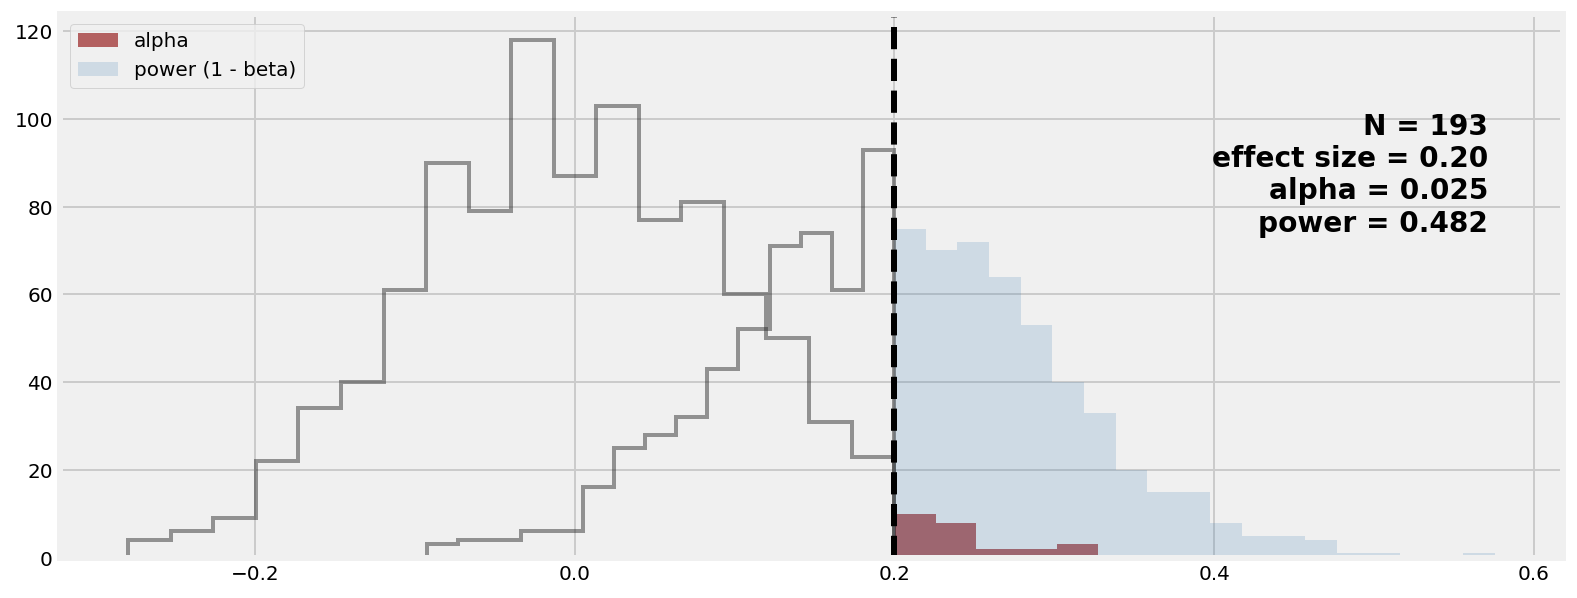

In [14]:
deltas = required_sample_plotter(std=1, desired_power=0.5, alpha=0.05, effect=0.2)